## Load necessary modules

In [1]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

import sys
sys.path.append('/host/workspace/keras-retinanet')
sys.path.append('/host/workspace/keras-retinanet/keras_retinanet/models')
# import keras_retinanet
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


## Load RetinaNet model

In [4]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('/host/data/corrections', 'snapshots5_augment', 'resnet18_csv_27.h5')

# load retinanet model
model = keras.models.load_model(model_path, custom_objects=custom_objects)
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {0: 'm'}

/usr/local/lib/python3.5/dist-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


In [3]:
model.save_weights('/host/data/corrections/snapshots4/resnet18_csv_09_weights.h5')


In [11]:
import tensorflow as tf
from keras import backend as K

from tensorflow.python.framework import tensor_shape, graph_util
from tensorflow.python.platform import gfile
K.set_learning_phase(0) # to get rid of learning rate and drop out\n",
sess = K.get_session()
output_graph_def = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(),
                                                               [model.outputs[-1].name.replace(':0', '')])
pb_path = os.path.join('/host/data/corrections', 'snapshots5_augment', 'resnet18_csv_27.pb')
with gfile.FastGFile(pb_path, 'wb') as f:
    f.write(output_graph_def.SerializeToString())
   

## Run detection on example

INFO:tensorflow:Froze 102 variables.
Converted 102 variables to const ops.


In [13]:
model.outputs

[<tf.Tensor 'regression/concat:0' shape=(?, ?, 4) dtype=float32>,
 <tf.Tensor 'classification/concat:0' shape=(?, ?, 1) dtype=float32>,
 <tf.Tensor 'nms/ExpandDims:0' shape=(1, ?, 5) dtype=float32>]

processing time:  0.16045475006103516


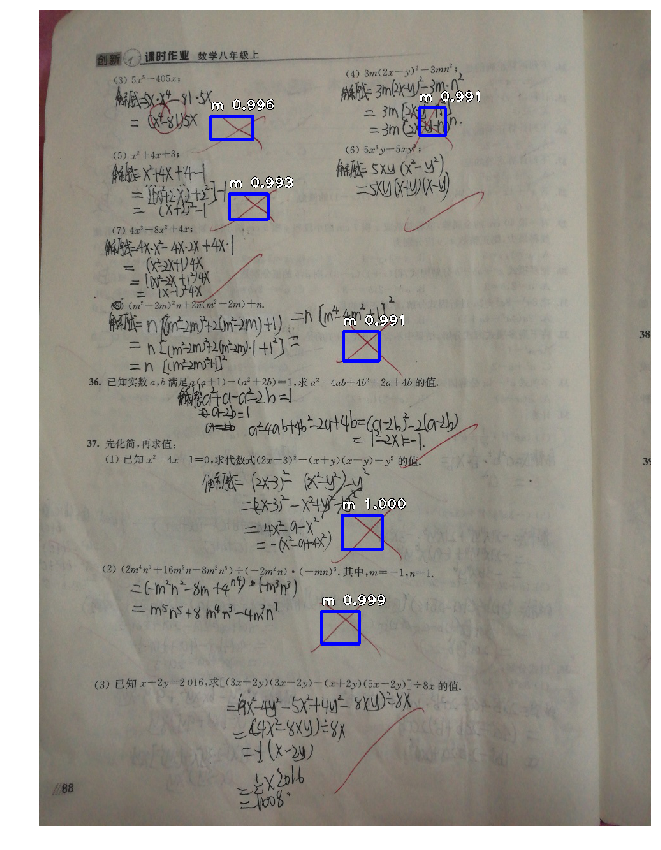

In [18]:
# load image
img_name = 'FuzP9W45BUxWI9LgDgD5BY59hZaH.jpg'
image = read_image_bgr(os.path.join('/host/data/corrections/5k/sheetimages', img_name))

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for networkimage = read_image_bgr(os.path.join('/host/data/corrections/5k/sheetimages', img_name))

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image, 960, 1280)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)

image = preprocess_image(image)
image, scale = resize_image(image, 960, 1280)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()